In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## 1. Load Datasets

In [ ]:
import pathlib
dataset_path = "/content/drive/MyDrive/testData/5dec/datasets"

data_dir = pathlib.Path(dataset_path)
!ls {data_dir}

angry  crying  happy


In [ ]:
#all images count in the dataset
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1800


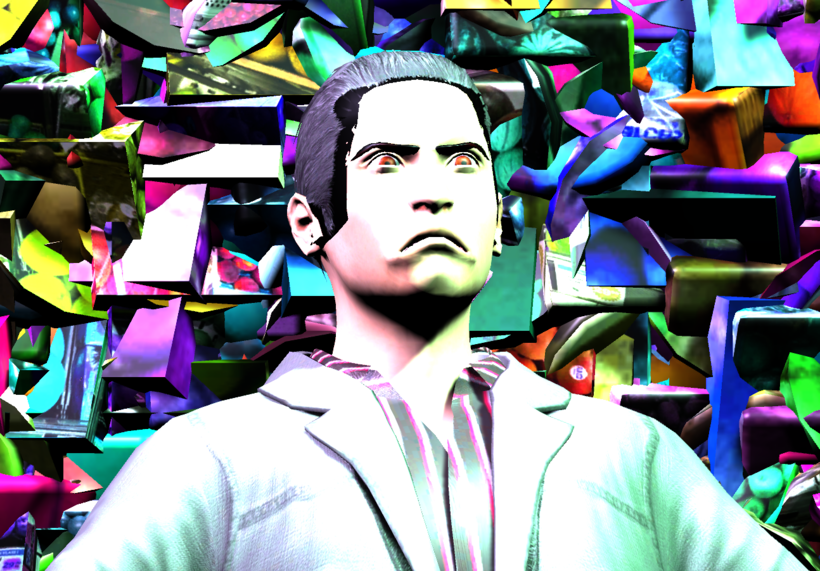

In [ ]:
#show first picture in the angry folder
angry_faces = list(data_dir.glob('angry/*'))
PIL.Image.open(str(angry_faces[1]))

##Data Preprocessing

In [ ]:
#define variable for later usage
batch_size = 32
img_height = 160
img_width = 160
image_size = (img_width, img_height)
print(image_size)

(160, 160)


train dataset

In [ ]:
#Spilt train data set from the whole data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=image_size,
  batch_size=batch_size)

Found 1800 files belonging to 3 classes.
Using 1440 files for training.


Validation dataset

In [ ]:
#Spilt validation data set from the whole data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=image_size,
  batch_size=batch_size)

Found 1800 files belonging to 3 classes.
Using 360 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names, num_classes)


['angry', 'crying', 'happy'] 3


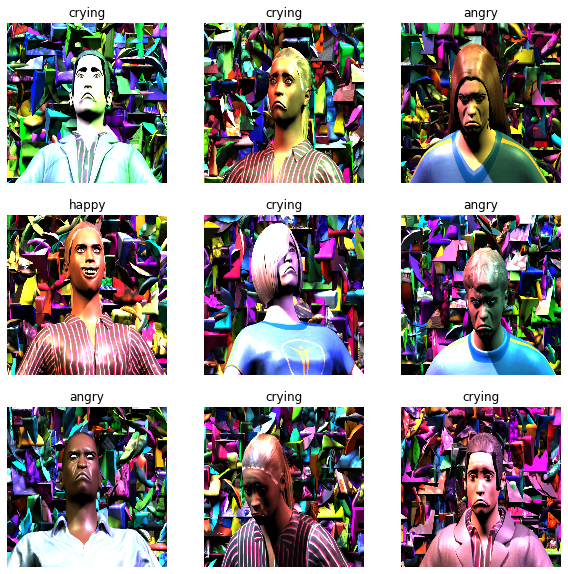

In [ ]:
#display some data examples

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#show validation data set content
for image_batch, labels_batch in val_ds:
  print('#images, pixels-width, pixels-height, RGB color: ', image_batch.shape)
  print('label vector:', labels_batch)
  print('labels shape:', labels_batch.shape)
  break

#images, pixels-width, pixels-height, RGB color:  (32, 160, 160, 3)
label vector: tf.Tensor([1 1 2 0 0 0 1 1 2 1 2 1 1 2 2 1 1 1 0 2 2 0 0 2 0 1 2 1 0 0 2 1], shape=(32,), dtype=int32)
labels shape: (32,)


In [ ]:
#show train data set content
for image_batch, labels_batch in train_ds:
  print('#images, pixels-width, pixels-height, RGB color: ', image_batch.shape)
  print('labels vector:', labels_batch)
  print('labels shape:', labels_batch.shape)
  break

#images, pixels-width, pixels-height, RGB color:  (32, 160, 160, 3)
labels vector: tf.Tensor([1 1 0 2 0 1 1 2 2 2 0 0 1 1 2 0 0 2 2 0 0 0 2 1 0 1 1 0 1 0 2 1], shape=(32,), dtype=int32)
labels shape: (32,)


### Create Test Data set


In [ ]:
#don't click here twice
#spilt 20% of validation data to test set
val_batches = tf.data.experimental.cardinality(val_ds)
#Avoid create test_ds from val more than once
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 10
Number of test batches: 2


### Configure the dataset for performance


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Rescale Images


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## 3. Create the base model from the pre-trained convnets

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
# 3 for RGB color so plue three here
image_shape = image_size + (3,)
print('input size', image_shape, image_size, )
#include_top mean does not know the classisfication layer
base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

input size (160, 160, 3) (160, 160)


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 4. Feature extraction

### Freeze the convolutional base

In [ ]:
#set all nodes in the model are not trainable
base_model.trainable = False

### Important note about BatchNormalization layers***
Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the Transfer learning guide.

In [ ]:
# Take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
#first connection layer after the model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
#prediction (output) layer
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
#define model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
print(x.shape)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
print(outputs.shape)
model = tf.keras.Model(inputs, outputs)
model.summary()

(None, 160, 160, 3)
(None, 3)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)         

In [ ]:
#update binary cross entropy(0 or 1 only)to SparseCategoricalCrossentropy (1 or more classes)
#model.compile() config the model with losses and metrics
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
              from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [ ]:
len(model.trainable_variables)

2

In [ ]:
#check init validation
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

10/10 [==============================] - 5s 461ms/step - loss: 1.1600 - accuracy: 0.3345


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.16
initial accuracy: 0.33


In [ ]:
#train with the datasets
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
45/45 [==============================] - 66s 1s/step - loss: 1.1452 - accuracy: 0.3271 - val_loss: 1.1256 - val_accuracy: 0.3074
Epoch 2/10
45/45 [==============================] - 66s 1s/step - loss: 1.1244 - accuracy: 0.3403 - val_loss: 1.1181 - val_accuracy: 0.3142
Epoch 3/10
45/45 [==============================] - 66s 1s/step - loss: 1.1173 - accuracy: 0.3382 - val_loss: 1.1150 - val_accuracy: 0.3277
Epoch 4/10
45/45 [==============================] - 68s 2s/step - loss: 1.1064 - accuracy: 0.3590 - val_loss: 1.1094 - val_accuracy: 0.3412
Epoch 5/10
45/45 [==============================] - 67s 1s/step - loss: 1.1018 - accuracy: 0.3597 - val_loss: 1.1060 - val_accuracy: 0.3412
Epoch 6/10
45/45 [==============================] - 66s 1s/step - loss: 1.0878 - accuracy: 0.3833 - val_loss: 1.0926 - val_accuracy: 0.3818
Epoch 7/10
45/45 [==============================] - 66s 1s/step - loss: 1.0790 - accuracy: 0.4174 - val_loss: 1.0890 - val_accuracy: 0.3750
Epoch 8/10
45/45 [==

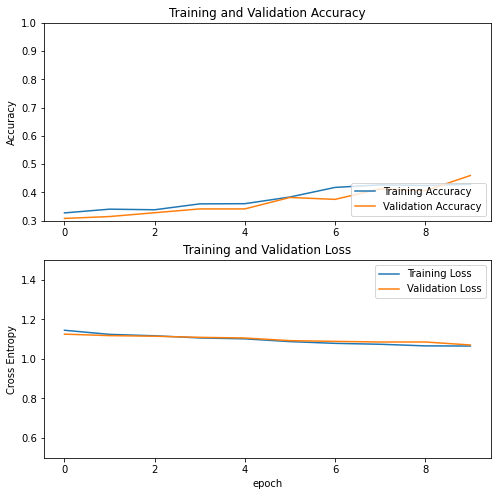

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.5,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


### Un-freeze the top layers of the model


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model


In [ ]:
#config the model again with new training parameter
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(
              from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [ ]:
len(model.trainable_variables)

58

### Continue training the model

In [ ]:
print(val_ds)
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)
print(history.epoch[-1])

<PrefetchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>
Epoch 10/20
45/45 [==============================] - 80s 2s/step - loss: 1.0369 - accuracy: 0.4826 - val_loss: 1.0116 - val_accuracy: 0.5338
Epoch 11/20
45/45 [==============================] - 82s 2s/step - loss: 0.9591 - accuracy: 0.6014 - val_loss: 0.9595 - val_accuracy: 0.5777
Epoch 12/20
45/45 [==============================] - 80s 2s/step - loss: 0.8973 - accuracy: 0.6653 - val_loss: 0.9034 - val_accuracy: 0.6622
Epoch 13/20
45/45 [==============================] - 79s 2s/step - loss: 0.8378 - accuracy: 0.7382 - val_loss: 0.8607 - val_accuracy: 0.7162
Epoch 14/20
45/45 [==============================] - 79s 2s/step - loss: 0.7892 - accuracy: 0.7882 - val_loss: 0.8113 - val_accuracy: 0.7736
Epoch 15/20
45/45 [==============================] - 79s 2s/step - loss: 0.7518 - accuracy: 0.8299 - val_loss: 0.7753 - val_accuracy: 0.7973
Epoch 16/20
45/45 [==============================] - 80s 2s/step -

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

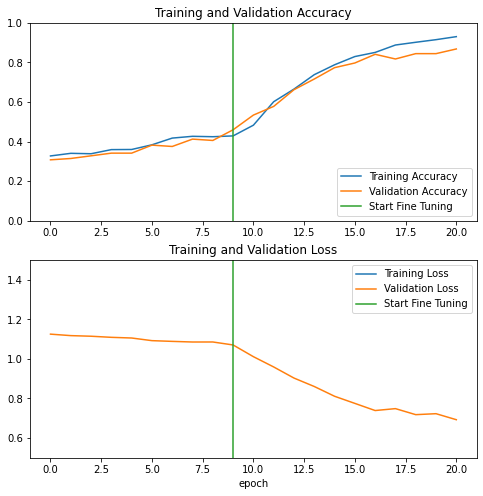

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0.5, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [108]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

2/2 [==============================] - 1s 485ms/step - loss: 0.7135 - accuracy: 0.8438
Test accuracy : 0.84375


Predictions on image :
 32 [[1.5332723e-02 9.8465121e-01 1.6134130e-05]
 [3.3127353e-01 6.6774541e-01 9.8097697e-04]
 [1.0868351e-03 9.9870133e-01 2.1185375e-04]
 [4.4270299e-04 9.9918681e-01 3.7042858e-04]
 [9.8748487e-01 1.2508205e-02 6.8988811e-06]
 [9.9926466e-01 9.2929196e-07 7.3436846e-04]
 [9.6210885e-01 2.1048675e-03 3.5786305e-02]
 [9.6656209e-01 3.3424228e-02 1.3704699e-05]
 [3.0917067e-03 5.2563222e-03 9.9165195e-01]
 [3.7498137e-03 9.9422836e-01 2.0218324e-03]
 [3.7763920e-03 1.9735354e-04 9.9602628e-01]
 [5.6933099e-01 4.3039075e-01 2.7829592e-04]
 [7.2370984e-02 9.2742878e-01 2.0024551e-04]
 [3.3618864e-02 4.5730970e-03 9.6180803e-01]
 [5.0755006e-01 4.8049805e-01 1.1951851e-02]
 [1.2080140e-02 9.8690200e-01 1.0179067e-03]
 [4.7774790e-03 2.2830800e-03 9.9293947e-01]
 [2.6140818e-02 9.6186972e-01 1.1989467e-02]
 [9.9975282e-01 4.4808607e-05 2.0233577e-04]
 [9.9059111e-01 8.5418560e-03 8.6697616e-04]
 [4.5642304e-01 3.1835136e-01 2.2522560e-01]
 [7.5865108e-01 2.3929718e-0

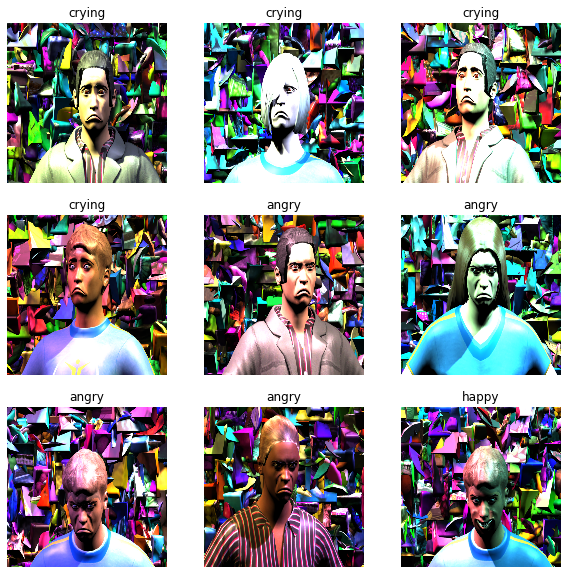

In [112]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print('Predictions on image :\n', len(predictions), predictions)

# Apply a soft max since our model returns logits (change to other activaton function)
predictions = tf.nn.softmax(predictions)
print('softmax Predictions:\n', predictions.numpy())

predictions = tf.argmax(predictions, axis=1)

print('Predictions class:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")